In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#### **Utility Functions**

In [2]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [3]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [4]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

#### **EDA**

In [5]:
df = pd.read_csv('AB_NYC_2019.csv')

In [6]:
df.head(1).T

,0
id,2539
name,Clean & quiet apt home by the park
host_id,2787
host_name,John
neighbourhood_group,Brooklyn
neighbourhood,Kensington
latitude,40.64749
longitude,-73.97237
room_type,Private room
price,149


In [7]:
df.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

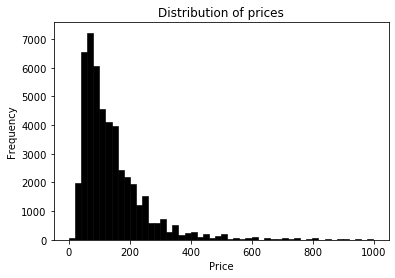

In [8]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price[df.price < 1000], bins=50, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

#### **Features**

In [9]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [10]:
base = ['latitude', 
        'longitude', 
        'price', 
        'minimum_nights', 
        'number_of_reviews', 
        'reviews_per_month', 
        'calculated_host_listings_count', 
        'availability_365']

In [11]:
df = df[base]

In [12]:
df.head(1).T

,0
latitude,40.64749
longitude,-73.97237
price,149.00000
minimum_nights,1.00000
number_of_reviews,9.00000
reviews_per_month,0.21000
calculated_host_listings_count,6.00000
availability_365,365.00000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48895 non-null  float64
 1   longitude                       48895 non-null  float64
 2   price                           48895 non-null  int64  
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               38843 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.0 MB


#### **Question 1**  
Find a feature with missing values. How many missing values does it have?

In [14]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#### **Question 2**  
What's the median (50% percentile) for variable 'minimum_nights'?

In [15]:
df.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [16]:
df.minimum_nights.median()

3.0

#### **Split the data**
* Shuffle the initial dataset, use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the np.log1p() function.

###### **Split your data in train/val/test sets, with 60%/20%/20% distribution**

In [17]:
n = len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

In [18]:
n - n_train - n_val - n_test

0

###### **Shuffle the initial dataset, use seed 42**

In [19]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [20]:
df_train = df.iloc[idx[: n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val :]]

In [21]:
len(df_train), len(df_val), len(df_test)

(29337, 9779, 9779)

In [22]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

###### **Apply the log transformation to the price variable using the np.log1p() function**

In [23]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

###### **Make sure that the target value ('price') is not in your dataframe**

In [24]:
del df_train['price']
del df_val['price']
del df_test['price']

##### **Question 3**  
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [25]:
df_train.isnull().sum()

latitude                             0
longitude                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 5998
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [26]:
df_train.reviews_per_month.describe()

count    23339.000000
mean         1.368549
std          1.653934
min          0.010000
25%          0.190000
50%          0.710000
75%          2.030000
max         27.950000
Name: reviews_per_month, dtype: float64

##### **3.1 Fill in missing values with 0**

In [27]:
fillna_val = 0

In [28]:
X_train = df_train.fillna(value=fillna_val).values
w0, w = train_linear_regression(X_train, y_train)

In [29]:
X_val = df_val.fillna(value=fillna_val).values
y_pred = w0 + X_val.dot(w)
val_score = round(rmse(y_pred, y_val), 2)
print('val score =', val_score)

val score = 0.64


##### **3.2 Fill in missing values with the mean**

In [30]:
mean_revs_per_month = df_train.reviews_per_month.mean()

In [31]:
fillna_val = mean_revs_per_month

In [32]:
X_train = df_train.fillna(value=fillna_val).values
w0, w = train_linear_regression(X_train, y_train)

In [33]:
X_val = df_val.fillna(value=fillna_val).values
y_pred = w0 + X_val.dot(w)
val_score = round(rmse(y_pred, y_val), 2)
print('val score =', val_score)

val score = 0.64


#### **Question 4**  
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?
* If there are multiple options, select the smallest r.

In [34]:
fillna_val = 0
r_vals = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

In [35]:
X_train = df_train.fillna(value=fillna_val).values

for r in r_vals:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = df_val.fillna(value=fillna_val).values
    y_pred = w0 + X_val.dot(w)
    val_score = round(rmse(y_pred, y_val), 2)
    print('score =', val_score, 'r =', r)

score = 0.64 r = 0
score = 0.64 r = 1e-06
score = 0.64 r = 0.0001
score = 0.64 r = 0.001
score = 0.66 r = 0.01
score = 0.68 r = 0.1
score = 0.68 r = 1
score = 0.68 r = 5
score = 0.68 r = 10


#### **Question 5**
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [36]:
df = pd.read_csv('AB_NYC_2019.csv')

base = ['latitude', 
        'longitude', 
        'price', 
        'minimum_nights', 
        'number_of_reviews', 
        'reviews_per_month', 
        'calculated_host_listings_count', 
        'availability_365']

df = df[base]

n = len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

fillna_val = 0

val_scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[: n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val :]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)
    
    del df_train['price']
    del df_val['price']
    del df_test['price']    
    
    X_train = df_train.fillna(value=fillna_val).values
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = df_val.fillna(value=fillna_val).values
    y_pred = w0 + X_val.dot(w)
    val_score = round(rmse(y_pred, y_val), 2)
    val_scores.append(val_score)
    print('seed =',seed, 'score =', val_score)
    
print ("\n", val_scores)

seed = 0 score = 0.65
seed = 1 score = 0.65
seed = 2 score = 0.65
seed = 3 score = 0.64
seed = 4 score = 0.64
seed = 5 score = 0.63
seed = 6 score = 0.63
seed = 7 score = 0.65
seed = 8 score = 0.65
seed = 9 score = 0.64

 [0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.65, 0.65, 0.64]


In [37]:
print('val score std dev =', round(np.std(val_scores), 3))

val score std dev = 0.008


#### **Question 6**
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [38]:
df = pd.read_csv('AB_NYC_2019.csv')

base = ['latitude', 
        'longitude', 
        'price', 
        'minimum_nights', 
        'number_of_reviews', 
        'reviews_per_month', 
        'calculated_host_listings_count', 
        'availability_365']

df = df[base]

n = len(df)
n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

seed = 9
fillna_val = 0
reg = 0.001

np.random.seed(seed)
idx = np.arange(n)
np.random.shuffle(idx)

df_train = df.iloc[idx[: n_train]]
df_val = df.iloc[idx[n_train : n_train + n_val]]

df_full_train = pd.concat([df_train, df_val])
df_test = df.iloc[idx[n_train + n_val :]]

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)

y_full_train = np.concatenate([y_train, y_val])
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']
del df_full_train['price']

X_full_train = df_full_train.fillna(value=fillna_val).values
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=reg)

X_test = df_test.fillna(value=fillna_val).values
y_pred = w0 + X_test.dot(w)

test_score = round(rmse(y_pred, y_test), 2)
print('test score =', test_score)

test score = 0.65
